# Characterizing the distribution of predicted and true metallicities

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
from scipy.optimize import minimize
%matplotlib inline

from IPython.display import display

PATH = os.path.abspath('../..')

# Load data

In [3]:
df = pd.read_csv(f'{PATH}/catalogs/predictions-oh_p50.csv', index_col=0)
df.head()

,oh_p50,prediction
objID,,
1237658493878337647,8.577997,8.696861
1237665330918850673,8.726439,8.757436
1237657630582178125,8.948060,9.024221
1237651250411405534,8.894798,9.015285
1237674651536261211,8.333275,8.544479


# Comparing predicted vs. true

## Binning

In [27]:
# Freedman-Diaconis bin size rule
binsize_true = 2 * (df.oh_p50.quantile(0.75) - df.oh_p50.quantile(0.25)) * df.oh_p50.size**(-1/3)
print(f'True Z binsize: {binsize_true:.4f}')

binsize_pred = 2 * (df.prediction.quantile(0.75) - df.prediction.quantile(0.25)) * df.prediction.size**(-1/3)
print(f'Predicted Z binsize: {binsize_pred:.4f}')

bins = 40
center = 8.7

histrange_true = [center - bins * binsize_true, center + bins * binsize_true]
histrange_pred = [center - bins * binsize_pred, center + bins * binsize_pred]



True Z binsize: 0.0180
Predicted Z binsize: 0.0163


## Plotting

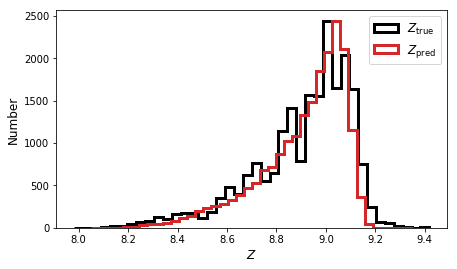

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.hist(df.oh_p50, bins=bins, range=histrange_true, color='k', histtype='step', lw=3, label=r'$Z_{\rm true}$');
ax.hist(df.prediction, bins=bins, range=histrange_pred, color='C3', histtype='step', lw=3, ls='-', label=r'$Z_{\rm pred}$')

ax.legend(fontsize=12, loc='upper right')

ax.set_xlabel('$Z$', fontsize=12)
ax.set_ylabel('Number', fontsize=12);

fig.savefig(f'{PATH}/results/03-Z_distribution.pdf')

# Comparing residual distribution

In [32]:
res = df.prediction - df.oh_p50

## bin size again

In [35]:
binsize_res = 2 * (res.quantile(0.75) - res.quantile(0.25)) * res.size**(-1/3)
print(f'Bin size: {binsize_res:.4f}')

bins = 40
center_res = 0

histrange_res = [-bins * binsize_res, bins * binsize_res]


'Bin size: 0.0066'

## Fit gaussian

[ 1.61336552e+03 -9.03712018e-03  6.28344646e-02]


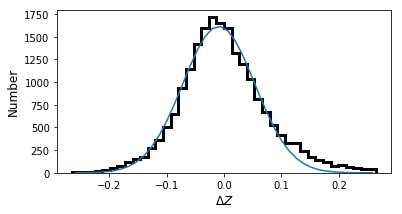

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

n, bin_edges, _ = ax.hist(res, bins=bins, range=histrange_res, color='k', histtype='step', lw=3)

# fit gaussian
def gaussian(x, amp, mu, std): 
    return amp*np.exp(-(x-mu)**2 / (2*std**2))

def mse_loss(params, x, y):
    return np.sum((gaussian(x, *params) - y)**2)
    

bin_centers = (bin_edges[:-1]+bin_edges[1:]) / 2

result = minimize(mse_loss, [1500, 0, 0.07], args=(bin_centers, n))

fit_normal = gaussian(bin_centers, *result['x'])

ax.plot(bin_centers, fit_normal, label='Best fit normal')


ax.set_xlabel('$\Delta Z$', fontsize=12)
ax.set_ylabel('Number', fontsize=12);

## Show with RMSE and NMAD

In [62]:
rmse = lambda z: np.sqrt(np.average((z)**2))
mad = lambda z: np.median(np.abs(z - np.median(z)))
nmad = lambda z: 1.4826 * mad(z)

In [63]:
print(rmse(res))
print(nmad(res))

0.08511842951594693
0.066793353900002


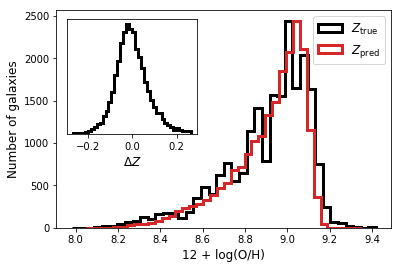

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(df.oh_p50, bins=bins, range=histrange_true, color='k', histtype='step', lw=3, label=r'$Z_{\rm true}$');
ax.hist(df.prediction, bins=bins, range=histrange_pred, color='C3', histtype='step', lw=3, ls='-', label=r'$Z_{\rm pred}$')

ax.legend(fontsize=12, loc='upper right')

ax.set_xlabel('12 + log(O/H)', fontsize=12)
ax.set_ylabel('Number of galaxies', fontsize=12);

# inset plot

ax_inset = fig.add_axes([0.15, 0.45, 0.3, 0.4])

n, bin_edges, _ = ax_inset.hist(res, bins=bins, range=histrange_res, color='k', histtype='step', lw=3)

ax_inset.set_xlabel('$\Delta Z$', fontsize=12)
ax_inset.set_yticks([])
#ax_inset.set_ylabel('Number', fontsize=12);

fig.savefig(f'{PATH}/results/03-Z_distribution.pdf')